In [1]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, precision_score
from data_processing import (
    getDatasets,
    create_statistical_features,
    perform_kmeans_clustering
)

In [2]:
# Load datasets
datasets = getDatasets()

# Road surface columns
surface_cols = ['dirt_road', 'cobblestone_road', 'asphalt_road']

# Combine left, right data and labels for each PVS
combined_datasets = pd.DataFrame({
    'pvs': list(datasets.keys()),
    'dataframe': [
        pd.concat([
            datasets[pvs_key]['data_left'].add_suffix('_left'),
            datasets[pvs_key]['data_right'].add_suffix('_right'),
            datasets[pvs_key]['data_labels'][surface_cols].idxmax(axis=1).rename('road_surface')
        ], axis=1)
        for pvs_key in datasets.keys()
    ]
})



In [3]:
# Encode road_surface labels for all PVS dataframes
surface_mapping = {
    'asphalt_road': 0,
    'cobblestone_road': 1,
    'dirt_road': 2
}

for df in combined_datasets['dataframe']:
    df['road_surface'] = df['road_surface'].map(surface_mapping).astype('int8')

In [4]:
combined_datasets.dataframe[0].head()  # Display the first few rows of the first PVS dataset

,timestamp_left,acc_x_dashboard_left,acc_y_dashboard_left,acc_z_dashboard_left,acc_x_above_suspension_left,acc_y_above_suspension_left,acc_z_above_suspension_left,acc_x_below_suspension_left,acc_y_below_suspension_left,acc_z_below_suspension_left,...,mag_y_above_suspension_right,mag_z_above_suspension_right,temp_dashboard_right,temp_above_suspension_right,temp_below_suspension_right,timestamp_gps_right,latitude_right,longitude_right,speed_right,road_surface
0,1.577219e+09,0.365116,0.167893,9.793961,0.327626,0.172733,9.781861,0.024797,0.172611,9.793824,...,14.911350,-14.487265,34.274628,34.035014,31.926408,1.577219e+09,-27.717841,-51.098865,0.009128,0
1,1.577219e+09,0.392649,0.176273,9.771216,0.381496,0.189492,9.699261,0.024797,0.194158,9.842905,...,13.572675,-13.254307,34.346512,33.891245,31.926408,1.577219e+09,-27.717841,-51.098865,0.009128,0
2,1.577219e+09,0.409408,0.181062,9.732909,0.283333,0.182310,9.807000,0.003249,0.227677,9.888395,...,13.498305,-12.637827,34.370474,34.274628,31.543026,1.577219e+09,-27.717841,-51.098865,0.009128,0
3,1.577219e+09,0.371101,0.164302,9.749668,0.314458,0.230194,9.739963,0.005643,0.172611,9.871635,...,13.498305,-12.637827,34.370474,33.939168,31.926408,1.577219e+09,-27.717841,-51.098865,0.009128,0
4,1.577219e+09,0.390255,0.159514,9.869378,0.344385,0.202660,9.762708,0.005643,0.200144,9.860862,...,14.688238,-15.103745,34.370474,33.939168,30.967952,1.577219e+09,-27.717841,-51.098865,0.009128,0


In [5]:
# Normalize sensor data and create statistical features over a rolling window
for i, row in combined_datasets.iterrows(): # iterate over each PVS dataframe, i = index, row = Series
    df = row['dataframe']
    
    # Normalize sensor data
    sensor_cols = df.columns.difference(['road_surface'])
    scaler = StandardScaler()

    # Keep only acc, gyro, mag, and speed sensor columns (plus label)
    allowed_keywords = ('acc', 'gyro', 'mag', 'speed')
    sensor_cols = [col for col in df.columns if col != 'road_surface' and any(k in col for k in allowed_keywords)]
    road_surface = df['road_surface']
    df = df[sensor_cols]
    df[sensor_cols] = scaler.fit_transform(df[sensor_cols])
    
    # Create statistical features
    df = create_statistical_features(df, sensor_cols, window_size=300)
    df['road_surface'] = road_surface # add back the labels

    if df.isnull().values.any():
        df = df.fillna(0)
    
    # Update the dataframe in the combined_datasets
    combined_datasets.at[i, 'dataframe'] = df # the .at accessor is used for fast scalar access

combined_datasets.dataframe[0].head()

/var/folders/6s/m9t5x_x135n5fwsph2741ffw0000gn/T/ipykernel_18881/31640324.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sensor_cols] = scaler.fit_transform(df[sensor_cols])
/Users/nicks/Library/CloudStorage/OneDrive-Personal/Documents/Python/M25_Capstone/Imperial-College-Capstone/notebooks/../src/data_processing.py:213: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{col}_std'] = data[col].rolling(window=window_size, min_periods=1).std()
/Users/nicks/Library/CloudStorage/OneDrive-Personal/Documents

,acc_x_dashboard_left_mean,acc_x_dashboard_left_std,acc_x_dashboard_left_var,acc_y_dashboard_left_mean,acc_y_dashboard_left_std,acc_y_dashboard_left_var,acc_z_dashboard_left_mean,acc_z_dashboard_left_std,acc_z_dashboard_left_var,acc_x_above_suspension_left_mean,...,mag_y_above_suspension_right_mean,mag_y_above_suspension_right_std,mag_y_above_suspension_right_var,mag_z_above_suspension_right_mean,mag_z_above_suspension_right_std,mag_z_above_suspension_right_var,speed_right_mean,speed_right_std,speed_right_var,road_surface
0,0.383223,0.000000,0.000000,0.078733,0.000000,0.000000,0.040739,0.000000,0.000000,0.332384,...,2.010413,0.000000,0.000000,2.157061,0.000000,0.000000,-1.232546,0.0,0.0,0
1,0.393058,0.013909,0.000193,0.080892,0.003053,0.000009,0.034531,0.008779,0.000077,0.353259,...,1.934513,0.107339,0.011522,2.171429,0.020319,0.000413,-1.232546,0.0,0.0,0
2,0.400327,0.015977,0.000255,0.082434,0.003435,0.000012,0.025491,0.016843,0.000284,0.334858,...,1.906402,0.090175,0.008132,2.181007,0.021947,0.000482,-1.232546,0.0,0.0,0
3,0.397120,0.014537,0.000211,0.081046,0.003946,0.000016,0.023258,0.014459,0.000209,0.331688,...,1.892346,0.078812,0.006211,2.185797,0.020319,0.000413,-1.232546,0.0,0.0,0
4,0.397932,0.012719,0.000162,0.079720,0.004525,0.000020,0.034988,0.029065,0.000845,0.334425,...,1.910899,0.079872,0.006380,2.177176,0.026101,0.000681,-1.232546,0.0,0.0,0


In [56]:
# Split data into training and testing sets - use specific PVS for training
selected_dfs_train = [combined_datasets['dataframe'][i] for i in [0, 1, 2, 6, 7, 8]]
# selected_dfs_train = [combined_datasets['dataframe'][i] for i in [0, 1, 2, 3, 4, 5]]
X_train = pd.concat(selected_dfs_train, ignore_index=True).drop(columns=['road_surface'])
y_train = pd.concat([df['road_surface'] for df in selected_dfs_train], ignore_index=True)

selected_dfs_test = [combined_datasets['dataframe'][i] for i in [3, 4, 5]]
# selected_dfs_test = [combined_datasets['dataframe'][i] for i in [6, 7, 8]]
X_test = pd.concat(selected_dfs_test, ignore_index=True).drop(columns=['road_surface'])
y_test = pd.concat([df['road_surface'] for df in selected_dfs_test], ignore_index=True)

print(f"train test split % : {len(X_train)/(len(X_train)+len(X_test))*100:.2f}% train, {len(X_test)/(len(X_train)+len(X_test))*100:.2f}% test")

train test split % : 66.45% train, 33.55% test


### Create KNN classifier

In [57]:
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
#joblib.dump(knn, '../models/knn_road_classification.pkl')

y_pred = knn.predict(X_test)

In [58]:
cm_1 = confusion_matrix(y_test, y_pred)#first row of the confusion matrix will be the true "No"s and second row "Yes"s
cm_1

array([[142237,   4074,    553],
       [   519,  94265,  12670],
       [   177,  10434,  97719]])

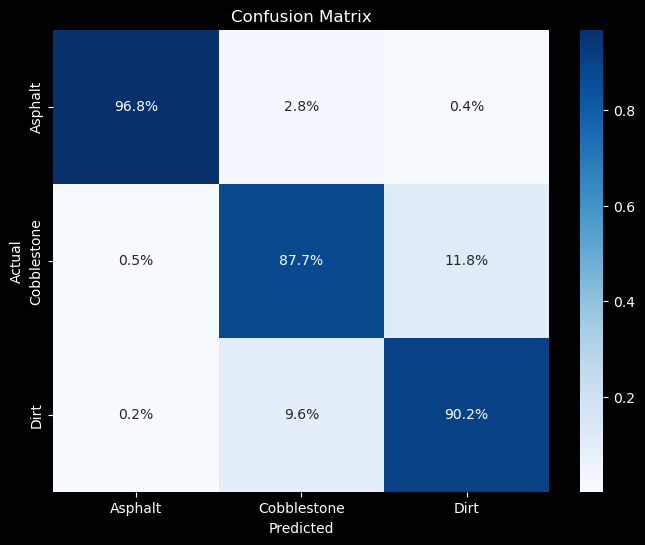

Overall accuracy: 92.1613%
              precision    recall  f1-score   support

     Asphalt       1.00      0.97      0.98    146864
 Cobblestone       0.87      0.88      0.87    107454
        Dirt       0.88      0.90      0.89    108330

    accuracy                           0.92    362648
   macro avg       0.91      0.92      0.91    362648
weighted avg       0.92      0.92      0.92    362648



In [59]:
# Plot additional KNN metrics: sensitivity (recall), specificity, precision, F1-score

# Class names ordered by encoded label
class_names = [k.replace('_road', '').replace('_', ' ').title()
               for k, v in sorted(surface_mapping.items(), key=lambda kv: kv[1])]

knn_test_accuracy = (y_pred == y_test.values).mean()
precision_per_class = precision_score(y_test, y_pred, average=None)
cm = cm_1

# 1) Normalized confusion matrix
cm_norm = cm / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='.1%', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# 4) Print summary
print(f"Overall accuracy: {knn_test_accuracy:.4%}")
print(classification_report(y_test, y_pred, target_names=class_names))

Core Metrics (Per Class):
1. Precision (Positive Predictive Value)
Question: "Of all the times I predicted this class, how often was I correct?". High precision means few false alarms for that class.

$$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}}$$


2. Recall (Sensitivity, True Positive Rate)
Question: "Of all the actual instances of this class, how many did I find?". High recall means you didn't miss many samples of that class.

$$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}$$

3. F1-Score (Harmonic Mean of Precision and Recall)
Question: "What's the balanced score between precision and recall?". F1-score is useful when you want to balance precision and recall. It's especially helpful for imbalanced classes.

$$\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision + Recall}}$$

4. Support
How many samples of this class are in the test set?

### Summary Metrics (Bottom Rows):

5. Accuracy
Overall percentage of correct predictions across all classes.

$$\text{Accuracy} = \frac{\text{Correct Predictions}}{\text{Total Predictions}}$$

6. Macro Average
Simple average of metrics across all classes (treats all classes equally).Use when: All classes are equally important, regardless of sample size.

7. Weighted Average
Weighted average of metrics by class support (larger classes have more influence).Use when: You want to account for class imbalance in your overall score.


## Support Vector Machines

In [67]:
# Create SVM classifier
from sklearn import svm
svm_mdl = svm.SVC(kernel = 'rbf', C=0.1, gamma='scale')
svm_mdl.fit(X_train, y_train)
#joblib.dump(svm_mdl, '../models/svm_road_classification.pkl')
#print("Support vectors:", svm_mdl.support_vectors_)

y_pred_svm = svm_mdl.predict(X_test)

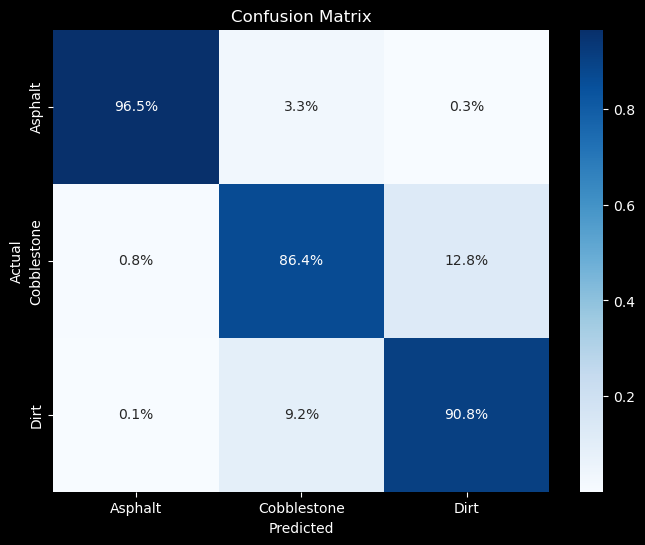

Overall accuracy: 91.7758%
              precision    recall  f1-score   support

     Asphalt       0.99      0.96      0.98    146864
 Cobblestone       0.86      0.86      0.86    107454
        Dirt       0.87      0.91      0.89    108330

    accuracy                           0.92    362648
   macro avg       0.91      0.91      0.91    362648
weighted avg       0.92      0.92      0.92    362648



In [ ]:
svm_test_accuracy = (y_pred_svm == y_test.values).mean()
cm_svm = confusion_matrix(y_test, y_pred_svm)

# 1) Normalized confusion matrix
cm_norm_svm = cm_svm / cm_svm.sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm_svm, annot=True, fmt='.1%', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# 4) Print summary
print(f"Overall accuracy: {svm_test_accuracy:.4%}")
print(classification_report(y_test, y_pred_svm, target_names=class_names))

# Test accuracy was 90.4% with C=1.0, gamma='scale'. Train accuray is 99.9%
# Changing gamma from scale reduced accuracy
# Test accuracy was 91.8% with C=0.1, gamma='scale'. - Reducing C allows more misclassifications during training, 
# which seems to improve generalization (less overfitting)